In [2]:
import torch
import torchvision 
import torchvision.transforms as tt
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split,ConcatDataset

In [4]:
norm_stats = ((0.51,0.48,0.45), (0.2,0.18,0.21))

train_transform = tt.Compose([
    tt.RandomHorizontalFlip(),
    tt.RandomCrop(32, padding=4, padding_mode='reflect'),
    tt.ToTensor(),
    tt.Normalize(*norm_stats)
])


test_transform = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*norm_stats)
])

In [5]:
train_data = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
test_data = torchvision.datasets.CIFAR100(root='./data', train=False, transform=test_transform)

Files already downloaded and verified


In [6]:
for image, label in train_data:
    print("Image shape: ", image.shape)
    print("Image tensor: ", image)
    print("Label: ", label)
    break

Image shape:  torch.Size([3, 32, 32])
Image tensor:  tensor([[[ 0.2735, -0.0794,  0.2735,  ...,  2.4500,  2.4500,  2.4304],
         [ 0.4696,  0.5284,  0.4696,  ...,  2.4500,  2.4500,  2.4304],
         [ 0.9598,  0.8029,  0.9598,  ...,  2.4500,  2.4500,  2.4304],
         ...,
         [-1.2755, -1.0598, -1.2755,  ...,  0.0775,  0.1951,  0.2343],
         [-1.1775, -0.9814, -1.1775,  ...,  0.6069,  0.5480,  0.5873],
         [-0.9618, -0.6873, -0.9618,  ...,  0.9598,  1.0186,  0.8029]],

        [[ 0.6449,  0.2309,  0.6449,  ...,  2.8889,  2.8889,  2.8671],
         [ 0.7974,  0.9499,  0.7974,  ...,  2.8889,  2.8889,  2.8671],
         [ 1.3638,  1.3856,  1.3638,  ...,  2.8889,  2.8889,  2.8889],
         ...,
         [-1.3159, -0.9891, -1.3159,  ...,  1.1024,  1.2331,  1.2985],
         [-1.3595, -1.0327, -1.3595,  ...,  1.6906,  1.6688,  1.7342],
         [-1.2070, -0.8148, -1.2070,  ...,  2.0392,  2.1264,  1.9303]],

        [[-0.0140, -0.0700, -0.0140,  ...,  2.6190,  2.6190,  2

In [8]:
train_classes_items = dict()

for train_item in train_data:
    label = train_data.classes[train_item[1]]
    if label not in train_classes_items:
        train_classes_items[label] = 1
    else:
        train_classes_items[label] += 1

train_classes_items

{'cattle': 500,
 'dinosaur': 500,
 'apple': 500,
 'boy': 500,
 'aquarium_fish': 500,
 'telephone': 500,
 'train': 500,
 'cup': 500,
 'cloud': 500,
 'elephant': 500,
 'keyboard': 500,
 'willow_tree': 500,
 'sunflower': 500,
 'castle': 500,
 'sea': 500,
 'bicycle': 500,
 'wolf': 500,
 'squirrel': 500,
 'shrew': 500,
 'pine_tree': 500,
 'rose': 500,
 'television': 500,
 'table': 500,
 'possum': 500,
 'oak_tree': 500,
 'leopard': 500,
 'maple_tree': 500,
 'rabbit': 500,
 'chimpanzee': 500,
 'clock': 500,
 'streetcar': 500,
 'cockroach': 500,
 'snake': 500,
 'lobster': 500,
 'mountain': 500,
 'palm_tree': 500,
 'skyscraper': 500,
 'tractor': 500,
 'shark': 500,
 'butterfly': 500,
 'bottle': 500,
 'bee': 500,
 'chair': 500,
 'woman': 500,
 'hamster': 500,
 'otter': 500,
 'seal': 500,
 'lion': 500,
 'mushroom': 500,
 'girl': 500,
 'sweet_pepper': 500,
 'forest': 500,
 'crocodile': 500,
 'orange': 500,
 'tulip': 500,
 'mouse': 500,
 'camel': 500,
 'caterpillar': 500,
 'man': 500,
 'skunk': 500

In [30]:
BATCH_SIZE = 128

train_dl = DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=True)
test_dl = DataLoader(test_data,BATCH_SIZE,num_workers=4,pin_memory=True)

In [31]:
def show_batch(dl):
    for batch in dl:
        images, labels = batch
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_yticks([])
        ax.set_xticks([])
        ax.imshow(make_grid(images[:20], nrow=5).permute(1,2,0))
        break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


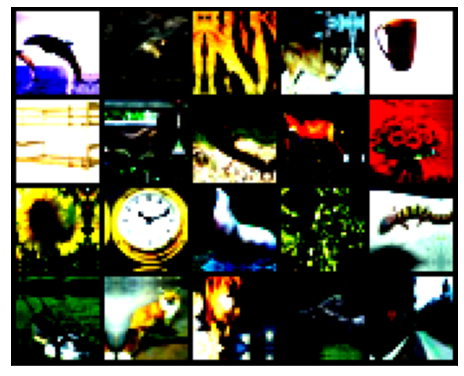

In [32]:
show_batch(train_dl)

In [45]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class ToDeviceLoader:
    def __init__(self, data, device):
        self.data = data
        self.device = device
        
    def __iter__(self):
        for batch in self.data:
            yield to_device(batch, self.device)
    
    def __len__(self):
        return len(self.data)

In [46]:
device = get_device()
print(device)

train_dl = ToDeviceLoader(train_dl, device)
test_dl = ToDeviceLoader(test_dl, device)

cuda


In [53]:
def accuracy(predicted, actual):
    _, predictions = torch.max(predicted, dim=1)
    return torch.tensor(torch.sum(predictions==actual).item()/len(predictions))

In [48]:
class BaseModel(nn.Module):
    def training_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {"val_loss":loss.detach(),"val_acc":acc}
    
    def validation_epoch_end(self,outputs):
        batch_losses = [loss["val_loss"] for loss in outputs]
        loss = torch.stack(batch_losses).mean()
        batch_accuracy = [accuracy["val_acc"] for accuracy in outputs]
        acc = torch.stack(batch_accuracy).mean()
        return {"val_loss":loss.item(),"val_acc":acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        
        

In [49]:
def conv_shortcut(in_channel,out_channel,stride):
    layers = [nn.Conv2d(in_channel,out_channel,kernel_size=(1,1),stride=(stride,stride)),
             nn.BatchNorm2d(out_channel)]
    return nn.Sequential(*layers)

def block(in_channel,out_channel,k_size,stride, conv=False):
    layers = None
    
    first_layers = [nn.Conv2d(in_channel,out_channel[0],kernel_size=(1,1),stride=(1,1)),
                    nn.BatchNorm2d(out_channel[0]),
                    nn.ReLU(inplace=True)]
    if conv:
        first_layers[0].stride=(stride,stride)
    
    second_layers = [nn.Conv2d(out_channel[0],out_channel[1],kernel_size=(k_size,k_size),stride=(1,1),padding=1),
                    nn.BatchNorm2d(out_channel[1])]

    layers = first_layers + second_layers
    
    return nn.Sequential(*layers)
    

class MResnet(BaseModel):
    
    def __init__(self,in_channels,num_classes):
        super().__init__()
        
        self.stg1 = nn.Sequential(
                                   nn.Conv2d(in_channels=in_channels,out_channels=64,kernel_size=(3),stride=(1),padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(inplace=True),
                                   nn.MaxPool2d(kernel_size=3,stride=2))
        
        ##stage 2
        self.convShortcut2 = conv_shortcut(64,256,1)
        
        self.conv2 = block(64,[64,256],3,1,conv=True)
        self.ident2 = block(256,[64,256],3,1)

        
        ##stage 3
        self.convShortcut3 = conv_shortcut(256,512,2)
        
        self.conv3 = block(256,[128,512],3,2,conv=True)
        self.ident3 = block(512,[128,512],3,2)

        
        ##stage 4
        self.convShortcut4 = conv_shortcut(512,1024,2)
        
        self.conv4 = block(512,[256,1024],3,2,conv=True)
        self.ident4 = block(1024,[256,1024],3,2)
        
        
        ##Classify
        self.classifier = nn.Sequential(
                                       nn.AvgPool2d(kernel_size=(4)),
                                       nn.Flatten(),
                                       nn.Linear(1024,num_classes))
        
    def forward(self,inputs):
        out = self.stg1(inputs)
        
        #stage 2
        out = F.relu(self.conv2(out) + self.convShortcut2(out))
        out = F.relu(self.ident2(out) + out)
        out = F.relu(self.ident2(out) + out)
        
        #stage3
        out = F.relu(self.conv3(out) + (self.convShortcut3(out)))
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)
        
#         stage4             
        out = F.relu(self.conv4(out) + (self.convShortcut4(out)))
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        
        out = self.classifier(out)#100x1024
        
        return out

In [50]:
model = MResnet(3,100)
model = to_device(model,device)

In [54]:
@torch.no_grad()
def evaluate(model,test_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_dl]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit (epochs,train_dl,test_dl,model,optimizer,max_lr,weight_decay,scheduler,grad_clip=None):
    torch.cuda.empty_cache()
    
    history = []
    
    optimizer = optimizer(model.parameters(),max_lr,weight_decay=weight_decay)
    
    scheduler = scheduler(optimizer,max_lr,epochs=epochs,steps_per_epoch=len(train_dl))
    
    for epoch in range(epochs):
        model.train()
        
        train_loss = []
        
        lrs = []
        
        for batch in train_dl:
            loss = model.training_step(batch)
            
            train_loss.append(loss)
            
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(),grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            scheduler.step()
            lrs.append(get_lr(optimizer))
        result = evaluate(model,test_dl)
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["lrs"] = lrs
        
        model.epoch_end(epoch,result)
        history.append(result)
        
    return history
            

In [55]:
history = [evaluate(model,test_dl)]

In [56]:
print(history)

[{'val_loss': 4.607317924499512, 'val_acc': 0.009889240376651287}]


In [57]:
epochs = 25
optimizer = torch.optim.SGD
max_lr=0.01
grad_clip = 0.1
weight_decay = 1e-4
scheduler = torch.optim.lr_scheduler.OneCycleLR

In [58]:
%%time
history += fit(epochs=epochs,train_dl=train_dl,test_dl=test_dl,model=model,optimizer=optimizer,max_lr=max_lr,grad_clip=grad_clip,
              weight_decay=weight_decay,scheduler=torch.optim.lr_scheduler.OneCycleLR)

Epoch [0], last_lr: 0.00082, train_loss: 3.8660, val_loss: 3.5463, val_acc: 0.1577
Epoch [1], last_lr: 0.00199, train_loss: 3.1928, val_loss: 3.1535, val_acc: 0.2224
Epoch [2], last_lr: 0.00372, train_loss: 2.9008, val_loss: 2.9068, val_acc: 0.2862
Epoch [3], last_lr: 0.00570, train_loss: 2.6349, val_loss: 2.8639, val_acc: 0.2886
Epoch [4], last_lr: 0.00760, train_loss: 2.3841, val_loss: 2.6285, val_acc: 0.3331
Epoch [5], last_lr: 0.00909, train_loss: 2.1780, val_loss: 2.4322, val_acc: 0.3681
Epoch [6], last_lr: 0.00990, train_loss: 1.9659, val_loss: 2.5031, val_acc: 0.3564
Epoch [7], last_lr: 0.00998, train_loss: 1.7990, val_loss: 2.3731, val_acc: 0.3899
Epoch [8], last_lr: 0.00982, train_loss: 1.6685, val_loss: 2.1955, val_acc: 0.4304
Epoch [9], last_lr: 0.00950, train_loss: 1.5277, val_loss: 2.2895, val_acc: 0.4092
Epoch [10], last_lr: 0.00904, train_loss: 1.4210, val_loss: 2.0718, val_acc: 0.4541
Epoch [11], last_lr: 0.00845, train_loss: 1.3310, val_loss: 2.1079, val_acc: 0.4459
Ep

In [61]:
def plot_acc(history):
    plt.plot([x["val_acc"] for x in history],"-x")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

def plot_loss(history):
    plt.plot([x.get("train_loss") for x in history], "-bx")
    plt.plot([x["val_loss"] for x in history],"-rx")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["train loss","val loss"])
    
def plot_lrs(history):
    plt.plot(np.concatenate([x.get("lrs",[]) for x in history]))
    plt.xlabel("Batch number")
    plt.ylabel("Learning rate")

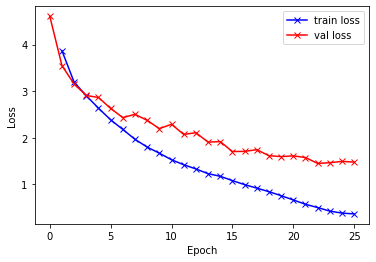

In [62]:
plot_loss(history)

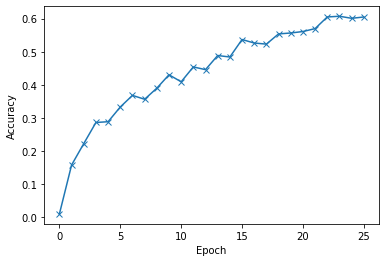

In [63]:
plot_acc(history)

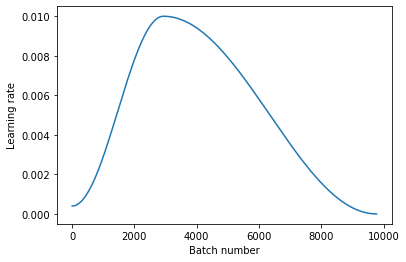

In [64]:
plot_lrs(history)

In [66]:
torch.save(model.state_dict(),"resnet.pth")